In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
from google.colab import drive, files
from io import BytesIO

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths and labels
checkpoint_dir = '/content/drive/MyDrive/FER_Checkpoints'
model_path = os.path.join(checkpoint_dir, 'best_emotion_model_gdrive.h5')  # or final_emotion_model.h5

# Emotion labels (same order as training)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(f"📁 Model path: {model_path}")
print(f"🏷️  Emotion labels: {emotion_labels}")

Mounted at /content/drive
📁 Model path: /content/drive/MyDrive/FER_Checkpoints/best_emotion_model_gdrive.h5
🏷️  Emotion labels: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


In [ ]:
def load_model():
    """Load the trained model"""
    try:
        model = tf.keras.models.load_model(model_path)
        print("✅ Model loaded successfully!")
        return model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

In [ ]:
def preprocess_image_enhanced(image_path, use_face_crop=True, apply_clahe=True):
    """
    Enhanced preprocessing with face detection, CLAHE, and better normalization
    """
    try:
        # Load image using PIL first (handles more formats including AVIF)
        if isinstance(image_path, str):
            pil_image = Image.open(image_path)
        else:
            pil_image = Image.open(BytesIO(image_path))

        if pil_image.mode != 'RGB':
            pil_image = pil_image.convert('RGB')

        image_array = np.array(pil_image)
        image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

        if image is None:
            raise ValueError("Failed to load image")

        # IMPROVEMENT 1: Face detection and cropping
        if use_face_crop:
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            gray_temp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_temp, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            if len(faces) > 0:
                # Use the largest face
                largest_face = max(faces, key=lambda f: f[2] * f[3])
                x, y, w, h = largest_face

                # Add padding around face (30% of face size)
                padding = int(0.3 * min(w, h))
                x = max(0, x - padding)
                y = max(0, y - padding)
                w = min(image.shape[1] - x, w + 2 * padding)
                h = min(image.shape[0] - y, h + 2 * padding)

                # Crop to face region
                image = image[y:y+h, x:x+w]
                print(f"✅ Face detected and cropped (size: {w}x{h})")
            else:
                print("⚠️ No face detected, using full image")

        # Convert to grayscale
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        # IMPROVEMENT 2: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        if apply_clahe:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            gray = clahe.apply(gray)

        # Resize to 48x48
        resized = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_CUBIC)

        # IMPROVEMENT 3: Better normalization
        normalized = resized.astype('float32') / 255.0

        # Global normalization
        # For FER2013-like datasets, these are typical values:
        GLOBAL_MEAN = 0.507  # Typical mean for face datasets
        GLOBAL_STD = 0.255   # Typical std for face datasets

        normalized = (normalized - GLOBAL_MEAN) / GLOBAL_STD

        # Reshape for model input
        processed = normalized.reshape(1, 48, 48, 1)

        return processed, resized, True  # Third value indicates face was found

    except Exception as e:
        print(f"❌ Error processing image: {e}")
        print("💡 Supported formats: JPG, PNG, BMP, TIFF, WEBP, AVIF")
        return None, None, False


def preprocess_image(image_path):
    """Original preprocessing function for backward compatibility"""
    processed, resized, _ = preprocess_image_enhanced(image_path)
    return processed, resized

print("✅ Enhanced image preprocessing function defined")

✅ Enhanced image preprocessing function defined


In [ ]:
def predict_emotion_enhanced(model, image_path, use_augmentation=True, num_augmentations=5):
    """
    Enhanced prediction with test-time augmentation and confidence calibration
    """
    try:
        # Get base prediction with enhanced preprocessing
        processed_orig, resized_orig, face_detected = preprocess_image_enhanced(image_path)

        if processed_orig is None:
            return None, None, None, False

        all_predictions = []

        # Base prediction
        pred_orig = model.predict(processed_orig, verbose=0)
        all_predictions.append(pred_orig[0])

        # Test-time augmentation for higher confidence
        if use_augmentation:
            print(f"🔄 Running {num_augmentations} augmented predictions...")

            for i in range(num_augmentations):
                # Create augmented version
                augmented = create_augmented_image(resized_orig)

                # Normalize the augmented image
                normalized = augmented.astype('float32') / 255.0
                normalized = (normalized - 0.507) / 0.255  # Use same normalization
                processed_aug = normalized.reshape(1, 48, 48, 1)

                # Get prediction
                pred_aug = model.predict(processed_aug, verbose=0)
                all_predictions.append(pred_aug[0])

        # Average all predictions
        avg_predictions = np.mean(all_predictions, axis=0)

        # Apply confidence calibration
        calibrated_probs = calibrate_confidence(avg_predictions)

        # Get final results
        predicted_class = np.argmax(calibrated_probs)
        confidence = np.max(calibrated_probs)
        predicted_emotion = emotion_labels[predicted_class]

        return predicted_emotion, confidence, calibrated_probs, face_detected

    except Exception as e:
        print(f"❌ Error making enhanced prediction: {e}")
        return None, None, None, False

def create_augmented_image(image):
    """Create augmented version of image for test-time augmentation"""
    augmented = image.copy()

    # Random rotation (-10 to +10 degrees)
    angle = np.random.uniform(-10, 10)
    if abs(angle) > 1:  # Only rotate if angle is significant
        rows, cols = image.shape
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        augmented = cv2.warpAffine(augmented, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    # Random brightness adjustment (±15%)
    brightness_factor = np.random.uniform(0.85, 1.15)
    augmented = np.clip(augmented * brightness_factor, 0, 255).astype(np.uint8)

    # Random noise (very small amount)
    if np.random.random() > 0.5:
        noise = np.random.normal(0, 2, augmented.shape).astype(np.float32)
        augmented = np.clip(augmented.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    return augmented

def calibrate_confidence(raw_predictions, temperature=1.2):
    """Apply temperature scaling to better calibrate confidence scores"""
    # Temperature scaling - reduces overconfidence
    scaled_logits = raw_predictions / temperature

    # Apply softmax to get calibrated probabilities
    exp_scaled = np.exp(scaled_logits - np.max(scaled_logits))  # Subtract max for numerical stability
    calibrated_probs = exp_scaled / np.sum(exp_scaled)

    return calibrated_probs

def predict_emotion(model, processed_image):
    """Original prediction function for backward compatibility"""
    try:
        predictions = model.predict(processed_image, verbose=0)
        predicted_class = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        predicted_emotion = emotion_labels[predicted_class]
        all_probs = predictions[0]

        return predicted_emotion, confidence, all_probs
    except Exception as e:
        print(f"❌ Error making prediction: {e}")
        return None, None, None

print("✅ Enhanced prediction functions defined")

✅ Enhanced prediction functions defined


In [ ]:
def display_results_enhanced(original_image, predicted_emotion, confidence, all_probs, face_detected, num_augmentations=0):
    """Enhanced display with more detailed analysis"""

    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Display original image
    ax1.imshow(original_image, cmap='gray')
    face_status = "✅ Face Detected" if face_detected else "⚠️ No Face"
    aug_status = f" | {num_augmentations} Augmentations" if num_augmentations > 0 else ""

    ax1.set_title(f'Input Image ({face_status}{aug_status})\nPredicted: {predicted_emotion}\nConfidence: {confidence:.3f}',
                 fontsize=12, fontweight='bold')
    ax1.axis('off')

    # Display probability bar chart
    colors = ['darkred' if i == np.argmax(all_probs) else 'lightcoral' if all_probs[i] > 0.1 else 'lightblue'
              for i in range(len(emotion_labels))]
    bars = ax2.bar(emotion_labels, all_probs, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_title('Emotion Probabilities (Calibrated)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Probability')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)

    # Add probability values on bars
    for bar, prob in zip(bars, all_probs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{prob:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Confidence analysis pie chart
    top_3_indices = np.argsort(all_probs)[-3:][::-1]  # Top 3 emotions
    top_3_probs = all_probs[top_3_indices]
    top_3_labels = [emotion_labels[i] for i in top_3_indices]
    other_prob = 1.0 - np.sum(top_3_probs)

    if other_prob > 0.001:  # Only show "Others" if significant
        pie_probs = list(top_3_probs) + [other_prob]
        pie_labels = top_3_labels + ['Others']
        pie_colors = ['gold', 'lightcoral', 'lightblue', 'lightgray']
    else:
        pie_probs = top_3_probs
        pie_labels = top_3_labels
        pie_colors = ['gold', 'lightcoral', 'lightblue']

    wedges, texts, autotexts = ax3.pie(pie_probs, labels=pie_labels, autopct='%1.1f%%',
                                       colors=pie_colors, startangle=90)
    ax3.set_title('Top Predictions', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Enhanced detailed results
    print("\n" + "="*60)
    print("🎭 ENHANCED FER PREDICTION RESULTS")
    print("="*60)

    # Confidence level interpretation
    if confidence >= 0.8:
        conf_level = "🟢 HIGH"
        reliability = "Very Reliable"
    elif confidence >= 0.6:
        conf_level = "🟡 MODERATE"
        reliability = "Moderately Reliable"
    elif confidence >= 0.4:
        conf_level = "🟠 LOW"
        reliability = "Less Reliable"
    else:
        conf_level = "🔴 VERY LOW"
        reliability = "Uncertain"

    print(f"🎯 Predicted Emotion: {predicted_emotion}")
    print(f"📊 Confidence Level: {conf_level} ({confidence:.4f} | {confidence*100:.2f}%)")
    print(f"🎪 Reliability: {reliability}")
    print(f"👤 Face Detection: {'✅ Success' if face_detected else '❌ Failed'}")

    # Uncertainty analysis
    entropy = -np.sum(all_probs * np.log(all_probs + 1e-10))  # Calculate entropy
    max_entropy = np.log(len(emotion_labels))  # Maximum possible entropy
    uncertainty = entropy / max_entropy

    print(f"🔍 Prediction Uncertainty: {uncertainty:.3f} (0=certain, 1=very uncertain)")

    # Top predictions
    print(f"\n📈 Detailed Emotion Rankings:")
    print("-" * 40)

    emotion_probs = list(zip(emotion_labels, all_probs))
    emotion_probs.sort(key=lambda x: x[1], reverse=True)

    for i, (emotion, prob) in enumerate(emotion_probs):
        if i == 0:
            emoji = "🏆"
            status = "PREDICTED"
        elif i == 1:
            emoji = "🥈"
            status = "2nd Choice"
        elif i == 2:
            emoji = "🥉"
            status = "3rd Choice"
        else:
            emoji = f"{i+1:2d}"
            status = ""

        bar_length = int(prob * 30)  # Visual bar
        bar = "█" * bar_length + "░" * (30 - bar_length)

        print(f"{emoji} {emotion:>8}: {prob:.4f} ({prob*100:5.2f}%) |{bar}| {status}")

    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    print("-" * 20)
    if not face_detected:
        print("⚠️  Try using an image with a clearer, more visible face")
    if confidence < 0.6:
        print("⚠️  Low confidence - consider testing with a different image")
        print("💡 Try images with: better lighting, frontal face view, clear facial expression")
    if uncertainty > 0.7:
        print("⚠️  High uncertainty detected - the emotion may be ambiguous")

    print("\n" + "="*60)

# Keep original function for backward compatibility
def display_results(original_image, predicted_emotion, confidence, all_probs):
    """Original display function for backward compatibility"""
    display_results_enhanced(original_image, predicted_emotion, confidence, all_probs, True, 0)

print("✅ Enhanced display results function defined")

✅ Enhanced display results function defined


In [ ]:
def test_face_detection(image_path):
    """Optional: Test if face is detected in image"""
    try:
        # Load OpenCV face detector
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Load image using PIL first (same as preprocessing)
        if isinstance(image_path, str):
            pil_image = Image.open(image_path)
        else:
            pil_image = Image.open(BytesIO(image_path))

        # Convert PIL image to RGB
        if pil_image.mode != 'RGB':
            pil_image = pil_image.convert('RGB')

        # Convert PIL to numpy array and then to OpenCV format
        image_array = np.array(pil_image)
        image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

        # Check if image was loaded successfully
        if image is None:
            print("⚠️  Could not load image for face detection")
            return False

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        if len(faces) > 0:
            print(f"✅ Face detected! Found {len(faces)} face(s)")
            return True
        else:
            print("⚠️  No face detected. Results may be less accurate.")
            return False

    except Exception as e:
        print(f"Face detection error: {e}")
        return False

print("✅ Face detection function defined")

✅ Face detection function defined


In [ ]:
# Load the model
print("Loading trained FER model...")
model = load_model()

if model is not None:
    print("\n" + "="*50)
    print("FER MODEL READY FOR TESTING!")
    print("="*50)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
else:
    print("❌ Cannot proceed without model. Please check your model path.")

Loading trained FER model...


✅ Model loaded successfully!

FER MODEL READY FOR TESTING!
Model input shape: (None, 48, 48, 1)
Model output shape: (None, 7)


🎭 ENHANCED FER TESTING
🖼️  Upload an image for advanced emotion recognition:
✨ Features: Face Detection + CLAHE + Test-Time Augmentation + Confidence Calibration

Click 'Choose Files' and select an image...


Saving 3088e05b-79b6-4bae-a6bf-5d85cd774882.jfif to 3088e05b-79b6-4bae-a6bf-5d85cd774882.jfif

📁 Processing uploaded image: 3088e05b-79b6-4bae-a6bf-5d85cd774882.jfif
🔄 Running enhanced analysis...
✅ Face detected and cropped (size: 3072x3363)
🔄 Running 5 augmented predictions...
✅ Face detected and cropped (size: 3072x3363)


/tmp/ipython-input-6-3019509642.py:50: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


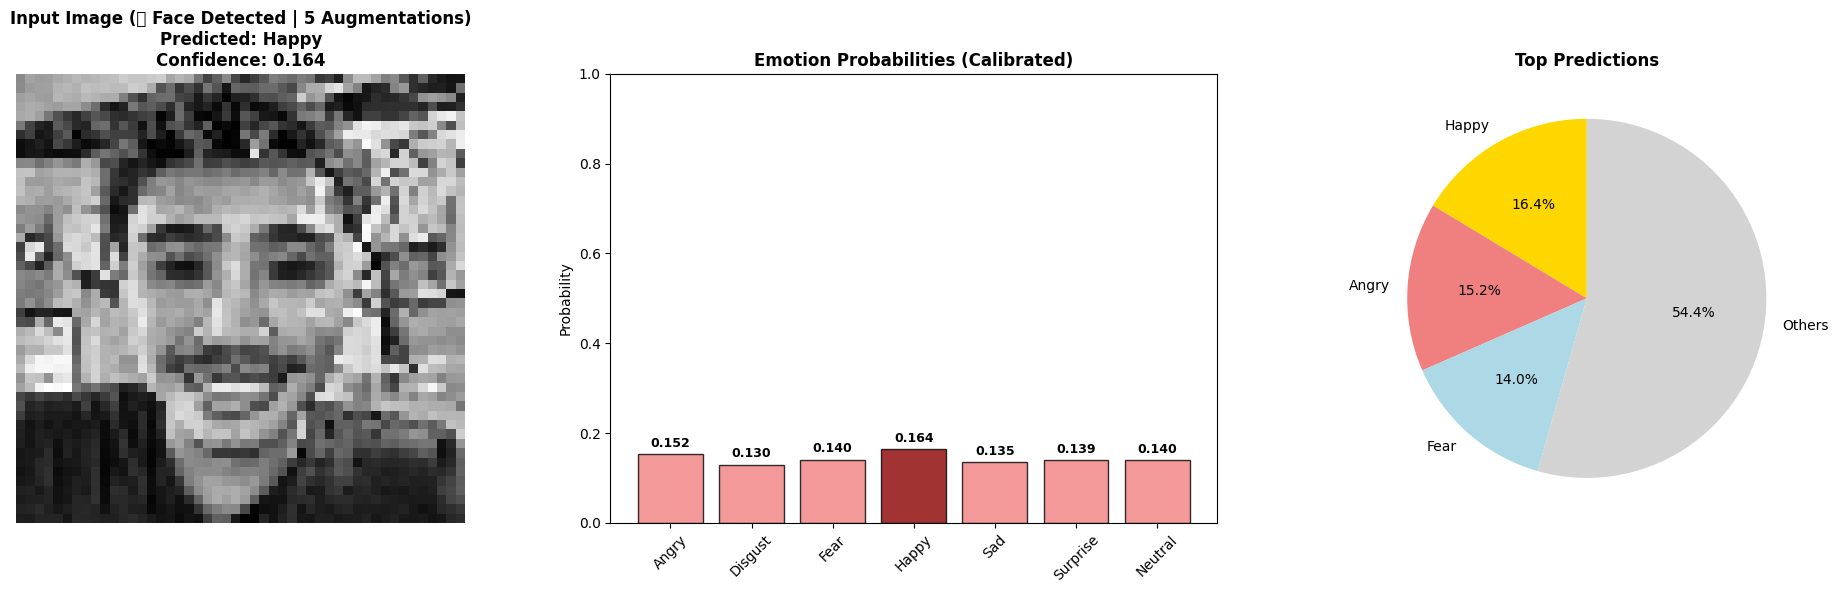


🎭 ENHANCED FER PREDICTION RESULTS
🎯 Predicted Emotion: Happy
📊 Confidence Level: 🔴 VERY LOW (0.1636 | 16.36%)
🎪 Reliability: Uncertain
👤 Face Detection: ✅ Success
🔍 Prediction Uncertainty: 0.999 (0=certain, 1=very uncertain)

📈 Detailed Emotion Rankings:
----------------------------------------
🏆    Happy: 0.1636 (16.36%) |████░░░░░░░░░░░░░░░░░░░░░░░░░░| PREDICTED
🥈    Angry: 0.1522 (15.22%) |████░░░░░░░░░░░░░░░░░░░░░░░░░░| 2nd Choice
🥉     Fear: 0.1401 (14.01%) |████░░░░░░░░░░░░░░░░░░░░░░░░░░| 3rd Choice
 4  Neutral: 0.1397 (13.97%) |████░░░░░░░░░░░░░░░░░░░░░░░░░░| 
 5 Surprise: 0.1393 (13.93%) |████░░░░░░░░░░░░░░░░░░░░░░░░░░| 
 6      Sad: 0.1354 (13.54%) |████░░░░░░░░░░░░░░░░░░░░░░░░░░| 
 7  Disgust: 0.1297 (12.97%) |███░░░░░░░░░░░░░░░░░░░░░░░░░░░| 

💡 RECOMMENDATIONS:
--------------------
⚠️  Low confidence - consider testing with a different image
💡 Try images with: better lighting, frontal face view, clear facial expression
⚠️  High uncertainty detected - the emotion may be ambi

In [ ]:
# Enhanced prediction pipeline with all improvements
if 'model' in globals() and model is not None:
    print("🎭 ENHANCED FER TESTING")
    print("="*50)
    print("🖼️  Upload an image for advanced emotion recognition:")
    print("✨ Features: Face Detection + CLAHE + Test-Time Augmentation + Confidence Calibration")
    print("\nClick 'Choose Files' and select an image...")

    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        image_data = uploaded[filename]

        print(f"\n📁 Processing uploaded image: {filename}")
        print("🔄 Running enhanced analysis...")

        # Use enhanced prediction with all improvements
        predicted_emotion, confidence, calibrated_probs, face_detected = predict_emotion_enhanced(
            model, image_data, use_augmentation=True, num_augmentations=5
        )

        if predicted_emotion is not None:
            # Get the processed image for display
            _, original_display, _ = preprocess_image_enhanced(image_data)

            # Display enhanced results
            display_results_enhanced(
                original_display, predicted_emotion, confidence,
                calibrated_probs, face_detected, num_augmentations=5
            )

            # Additional analysis
            print(f"\n🔬 TECHNICAL DETAILS:")
            print(f"📊 Image processed with: {'✅ Face cropping' if face_detected else '❌ Full image'}")
            print(f"🎨 Preprocessing: CLAHE enhancement applied")
            print(f"🔄 Augmentation: 5 variations tested and averaged")
            print(f"🎯 Calibration: Temperature scaling applied")

        else:
            print("❌ Failed to make enhanced prediction")
            print("💡 Falling back to basic prediction...")

            # Fallback to basic prediction
            processed_image, original_image = preprocess_image(image_data)
            if processed_image is not None:
                predicted_emotion, confidence, all_probs = predict_emotion(model, processed_image)
                if predicted_emotion is not None:
                    display_results(original_image, predicted_emotion, confidence, all_probs)

    print("\n" + "="*60)
    print("🔄 TESTING OPTIONS:")
    print("• Re-run this cell to test another image")
    print("• Try different types of images (various angles, lighting, expressions)")
    print("• Compare results with different image qualities")
    print("="*60)

    # Quick testing tips
    print("\n💡 TIPS FOR BEST RESULTS:")
    print("✅ Use clear, well-lit facial images")
    print("✅ Frontal or near-frontal face angles work best")
    print("✅ Single person images are preferred")
    print("✅ Avoid heavy shadows or extreme lighting")
    print("✅ JPEG, PNG, WEBP, AVIF formats all supported")

else:
    print("❌ Model not loaded. Please run the previous cells first.")

In [ ]:
# Optional: Test with image from URL
# Uncomment and modify the code below to test with image URLs

"""
import requests

# Replace with your image URL
image_url = "YOUR_IMAGE_URL_HERE"

try:
    response = requests.get(image_url)
    image_data = response.content

    print(f"📁 Processing image from URL: {image_url}")

    # Optional face detection
    test_face_detection(image_data)

    # Preprocess image
    processed_image, original_image = preprocess_image(image_data)

    if processed_image is not None:
        # Make prediction
        predicted_emotion, confidence, all_probs = predict_emotion(model, processed_image)

        if predicted_emotion is not None:
            # Display results
            display_results(original_image, predicted_emotion, confidence, all_probs)
        else:
            print("❌ Failed to make prediction")
    else:
        print("❌ Failed to process image")

except Exception as e:
    print(f"❌ Error loading image from URL: {e}")
"""

print("💡 To test with URL: Uncomment and modify the code above")

💡 To test with URL: Uncomment and modify the code above
